### Desenvolvendo o Modelo de Série Temporal

O objetivo aqui é analisar a nossa série temporal para podermos ajustar um LSTM, e como o modelo é de deep learning, quanto mais dado melhor para nós.

In [5]:
# Libs:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Carregando os dados que baixamos pelo yfinance:
dataset = pd.read_csv(r"C:\Users\lucaa\Desktop\TechChallenge - Fase4\data\raw\dataset_PETR_st.csv")
dataset.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,Acao
0,2018-01-02,5.312316,16.549999,16.549999,16.190001,16.190001,33461800,PETR4
1,2018-01-03,5.360464,16.700001,16.719999,16.370001,16.490000,55940900,PETR4


In [7]:
# Describe da nossa dataset:
dataset.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1.656000e+03
mean,14.627233,27.563744,27.969674,27.156824,27.566727,6.591767e+07
std,9.404082,5.996867,6.001735,5.970058,5.974129,3.587860e+07
min,3.906060,11.290000,12.180000,10.850000,11.070000,0.000000e+00
25%,8.185170,23.495000,23.922500,23.127500,23.500000,4.292908e+07
50%,10.089991,27.180000,27.585000,26.820000,27.224999,5.785545e+07
75%,17.990360,30.832500,31.232500,30.342500,30.879999,7.933302e+07
max,39.599998,42.900002,42.939999,42.560001,42.770000,4.902304e+08


C:\Users\lucaa\AppData\Local\Temp\ipykernel_5488\3118577618.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datas_mensais = pd.to_datetime(pd.date_range(start = dataset["Date"].min(), end = dataset["Date"].max(), freq = 'Y'))


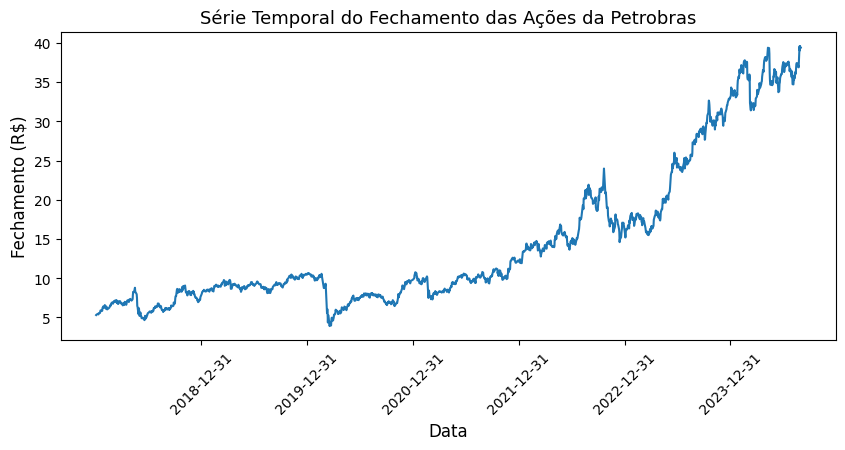

In [8]:
# Vamos plotar nossa série:

# Selecionando datas especificas para plotar:
datas_mensais = pd.to_datetime(pd.date_range(start = dataset["Date"].min(), end = dataset["Date"].max(), freq = 'Y'))

# Plotando a série temporal
plt.figure(figsize=(10, 4))
sns.lineplot(x = 'Date', y='Adj Close', data = dataset.assign(Date = lambda df_: pd.to_datetime(df_.Date)))
plt.xticks(datas_mensais, rotation = 45)
plt.title('Série Temporal do Fechamento das Ações da Petrobras', fontsize = 13)
plt.xlabel('Data', fontsize = 12)
plt.ylabel('Fechamento (R$)', fontsize = 12)
plt.show()

Comentando a série acima, podemos ver que não necessariamente podemos usar só uma parte para modelagem e predição, visto que o comportamento é linear ao longo do tempo, isto é, se usassemos somente os dados de 2022 pra trás, teriamos péssimas predições para dias atuais, onde o preço médio da ação aumentou significativamente. Dessa forma, importante utilizarmos um treinamento de até dias atuais, separando os últimos 60 dias, por exemplo, para validação do nosso modelo.

### Modelando a ST com LSTM

In [9]:
# Libs para modelagem:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
# Serie do Fechamento:
st_close = dataset['Adj Close'].values.reshape(-1, 1)
st_close

array([[ 5.31231594],
       [ 5.3604641 ],
       [ 5.37009287],
       ...,
       [39.59999847],
       [39.33000183],
       [39.36999893]])

In [11]:
# Normalizando a Serie - usando o MinMax (convergencia facilitada):
scaler = MinMaxScaler()
st_close_scaled = scaler.fit_transform(st_close)
st_close_scaled

array([[0.03939763],
       [0.04074654],
       [0.0410163 ],
       ...,
       [1.        ],
       [0.99243578],
       [0.99355634]])

In [12]:
# Função para criar sequências de datas:
def sequencia(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [13]:
# Parâmetros de treinamento do LSTM:
seq_length = 10
split_ratio = 0.7

In [14]:
# Criar sequências
X, y = sequencia(st_close_scaled, seq_length)

In [15]:
# Dividindo os splits para treinametno e teste:
train_size = int(len(X) * split_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [45]:
# Modelo LSTM:
model_1 = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

c:\Users\lucaa\Desktop\TechChallenge - Fase4\env_name\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model_1.compile(optimizer='adam', loss='mse')

In [47]:
# Treinando:
history = model_1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0098 - val_loss: 0.0319
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3092e-04 - val_loss: 0.0014
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1326e-04 - val_loss: 0.0020
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1759e-04 - val_loss: 0.0028
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0353e-04 - val_loss: 0.0016
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4115e-04 - val_loss: 0.0017
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7020e-04 - val_loss: 0.0010
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2035e-04 - val_loss: 0.0015
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8179e-04 - val_loss: 0.0010
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4713e-04 - val_loss: 0.0016
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━

In [48]:
# Fazer previsões
y_pred = model_1.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [49]:
# Reverter normalização
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

In [50]:
# Calcular métricas
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

In [51]:
print(f'\nMétricas de Avaliação:')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')


Métricas de Avaliação:
MAE: 1.39
RMSE: 1.89
MAPE: 4.63%


Ótimas métricas para um modelo que nem é tunado de serta forma, então acredito que nem seria necessário um tuning, mas como a ideia é implementar a técnica em si, vamos tentar otimizar alguns paramétros para termos uma melhora na performance e também evitar um overfitting.

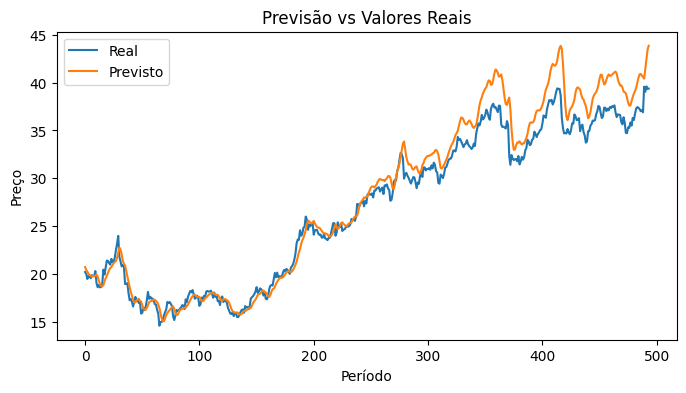

In [52]:
# Plotando o modelo ajustado:
plt.figure(figsize=(8, 4))
plt.plot(y_test_orig, label='Real')
plt.plot(y_pred_orig, label='Previsto')
plt.title('Previsão vs Valores Reais')
plt.xlabel('Período')
plt.ylabel('Preço')
plt.legend()
plt.show()

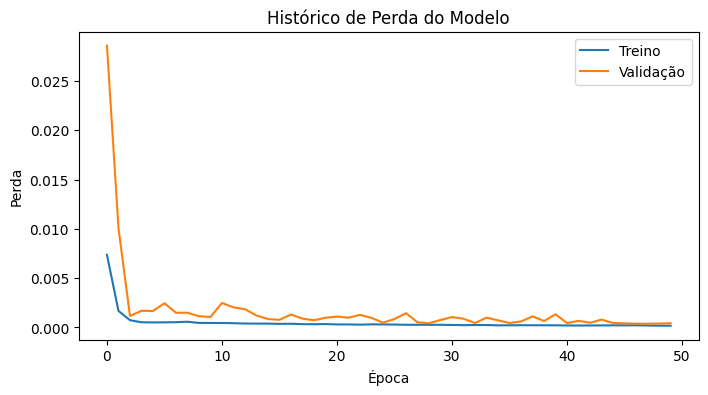

In [24]:
# Plotando o histórico dessa perda:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Histórico de Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

### Otimização de Hiperparâmetros

In [53]:
from tensorflow.keras.optimizers import Adam

Vamos adicionar uma etapa de tuning mas somente testando o learning rate para verificar uma possibilidade de reduzir o risco de overfitting.

In [54]:
# Utilizando um otimizador:
optimizer = Adam(
    learning_rate = 0.001 # somente o learning rate, porque a previsao já esta boa, nos preocupa mais o overfitting
)
model_1.compile(optimizer=optimizer, loss='mse')

In [55]:
# Treinando - Tuning:
history = model_1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.9162e-04 - val_loss: 5.2843e-04
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4866e-04 - val_loss: 3.0689e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0076e-04 - val_loss: 2.9715e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6643e-04 - val_loss: 6.5067e-04
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4614e-04 - val_loss: 6.8359e-04
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7228e-04 - val_loss: 2.6128e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7365e-04 - val_loss: 4.3060e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4382e-04 - val_loss: 4.4617e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4493e-04 - val_loss: 0.0015
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8270e-04 - val_loss: 3.0143e-04
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6949e-04 - val_loss: 

In [57]:
# Avaliação
y_pred_tuning = model_1.predict(X_test)
# Reverter normalização
y_test_orig_tuning = scaler.inverse_transform(y_test)
y_pred_orig_tuning = scaler.inverse_transform(y_pred_tuning)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [58]:
# Métricas
mae = mean_absolute_error(y_test_orig_tuning, y_pred_orig_tuning)
rmse = np.sqrt(mean_squared_error(y_test_orig_tuning, y_pred_orig_tuning))
mape = np.mean(np.abs((y_test_orig_tuning - y_pred_orig_tuning) / y_test_orig_tuning)) * 100

In [59]:
print(f'\nMétricas de Avaliação:')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')


Métricas de Avaliação:
MAE: 0.62
RMSE: 0.82
MAPE: 2.40%


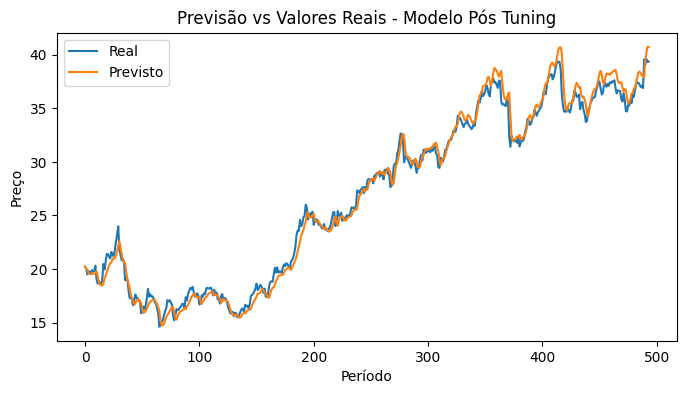

In [60]:
# Plotando o modelo tunado:
plt.figure(figsize=(8, 4))
plt.plot(y_test_orig_tuning, label='Real')
plt.plot(y_pred_orig_tuning, label='Previsto')
plt.title('Previsão vs Valores Reais - Modelo Pós Tuning')
plt.xlabel('Período')
plt.ylabel('Preço')
plt.legend()
plt.show()

### Exportando o Modelo

In [61]:
import joblib
import json
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, save_model
import os

In [140]:
path = "C:\\Users\\lucaa\\Desktop\\TechChallenge - Fase4\\models\\{}"

In [141]:
# Salvar o modelo no formato H5
save_model(model_1, path.format("modelo_lstm.h5"))

In [142]:
# Salvar a arquitetura do modelo em JSON
with open(path.format("modelo_arquitetura.json"), 'w') as json_file:
    json_file.write(model_1.to_json())

In [143]:
# Salvar os pesos separadamente
model_1.save_weights(path.format("modelo.weights.h5"))

In [144]:
# Salvar o scaler
joblib.dump(scaler, path.format("scaler.pkl"))

['C:\\Users\\lucaa\\Desktop\\TechChallenge - Fase4\\models\\scaler.pkl']

In [145]:
# Salvar parâmetros importantes
params = {
    'sequence_length': seq_length,
    'input_shape': model_1.input_shape[1:],
    'output_shape': model_1.output_shape[1:],
    'model_version': '1.0'
}
with open(path.format("parametros.json"), 'w') as f:
    json.dump(params, f)

In [92]:
dataset_petr = pd.read_csv(r"C:\Users\lucaa\Desktop\TechChallenge - Fase4\data\raw\dataset_PETR_st.csv")
def puxa_janela_fechamento(n_days = None):
    if n_days is None:
        return {"error": f"Precisa informar uma janela"}
    return np.array(dataset_petr["Adj Close"][len(dataset_petr)-n_days:len(dataset_petr)].tolist())

In [93]:
puxa_janela_fechamento(n_days = 10)

array([37.37628174, 37.23043442, 37.00680161, 37.11999893, 36.88999939,
       39.56999969, 39.04000092, 39.59999847, 39.33000183, 39.36999893])

In [84]:
dataset_petr.tail(3)

,Date,Adj Close,Close,High,Low,Open,Volume,Acao
1653,2024-08-28,39.599998,39.599998,39.860001,38.779999,38.939999,43284500,PETR4
1654,2024-08-29,39.330002,39.330002,39.830002,39.279999,39.650002,25356600,PETR4
1655,2024-08-30,39.369999,39.369999,39.650002,38.880001,39.220001,84437200,PETR4


In [104]:
def cria_nova_lista(lista_real, valor_pred):
    nova_lista = lista_real.copy()
    nova_lista = nova_lista[1:]
    return np.append(nova_lista, valor_pred)

In [107]:
cria_nova_lista(puxa_janela_fechamento(n_days = 10), 10)

array([37.23043442, 37.00680161, 37.11999893, 36.88999939, 39.56999969,
       39.04000092, 39.59999847, 39.33000183, 39.36999893, 10.        ])

In [139]:
dataset_petr.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,Acao
1651,2024-08-26,39.570000,39.570000,39.610001,37.709999,37.860001,102270300,PETR4
1652,2024-08-27,39.040001,39.040001,39.369999,38.950001,39.250000,35073100,PETR4
1653,2024-08-28,39.599998,39.599998,39.860001,38.779999,38.939999,43284500,PETR4
1654,2024-08-29,39.330002,39.330002,39.830002,39.279999,39.650002,25356600,PETR4
1655,2024-08-30,39.369999,39.369999,39.650002,38.880001,39.220001,84437200,PETR4


In [157]:
from tensorflow.keras.models import model_from_json
import joblib
import json
import numpy as np
from fastapi import FastAPI
import uvicorn
from pydantic import BaseModel
import pandas as pd


# Carregando infos das ações para usar na API:
dataset_petr = pd.read_csv(r"C:\Users\lucaa\Desktop\TechChallenge - Fase4\data\raw\dataset_PETR_st.csv")
input_janela = np.array(dataset_petr["Adj Close"][len(dataset_petr)-10:len(dataset_petr)].tolist())

def load_model(model_dir):

    with open(f'{model_dir}/modelo_arquitetura.json', 'r') as f:
        model_json = f.read()
    model = model_from_json(model_json)
    model.load_weights(f'{model_dir}/modelo.weights.h5')
    scaler = joblib.load(f'{model_dir}/scaler.pkl')
    with open(f'{model_dir}/parametros.json', 'r') as f:
        params = json.load(f)
    
    return model, scaler, params

def valida_input(input_data, scaler, sequence_length):
    # Normalizar e formatar entrada
    scaled_data = scaler.transform(input_data.reshape(-1, 1))
    return scaled_data.reshape(1, sequence_length, 1)

def pred(model, processed_input):
    return model.predict(processed_input)

def cria_nova_lista(lista_real, valor_pred):
    nova_lista = lista_real.copy()
    nova_lista = nova_lista[1:]
    return np.append(nova_lista, valor_pred) 

In [158]:
# Carregar componentes do modelo
model, scaler, params = load_model('C:\\Users\\lucaa\\Desktop\\TechChallenge - Fase4\\models')
seq_length = params['sequence_length']

c:\Users\lucaa\Desktop\TechChallenge - Fase4\env_name\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [159]:
input_janela

array([37.37628174, 37.23043442, 37.00680161, 37.11999893, 36.88999939,
       39.56999969, 39.04000092, 39.59999847, 39.33000183, 39.36999893])

In [175]:
# Puxando e modificando os inputs:
processed_input_inicial = valida_input(input_janela, scaler, seq_length) # Normalizando o input dos 10 dias - sequence
lista_pred = []
processed_input_inicial

array([[[0.93770044],
        [0.93361439],
        [0.9273491 ],
        [0.93052043],
        [0.92407677],
        [0.99915956],
        [0.98431113],
        [1.        ],
        [0.99243578],
        [0.99355634]]])

In [176]:
# Predizendo recursivamente:
n_days = 10
for i in range(n_days):
    v_pred = float(pred(model, processed_input_inicial)[0][0])
    new_input = cria_nova_lista(processed_input_inicial[0], v_pred)
    processed_input_inicial = np.array(new_input).reshape(1, seq_length, 1)
    lista_pred.append(v_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [187]:
np.array([[23]])

array([[23]])

In [179]:
lista_pred

[1.0301036834716797,
 1.0529381036758423,
 1.083304524421692,
 1.118227243423462,
 1.1571507453918457,
 1.2007708549499512,
 1.249101996421814,
 1.3039684295654297,
 1.3668948411941528,
 1.4406311511993408]

In [186]:
float(scaler.inverse_transform(pred(model, processed_input_inicial))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


58.461788177490234

In [189]:
[float(scaler.inverse_transform(np.array([[x]]))[0][0]) for x in lista_pred]

[40.674517514748445,
 41.48956791594408,
 42.57346508480096,
 43.819994485536355,
 45.209327589316544,
 46.766301117772954,
 48.49142993184741,
 50.449829048008255,
 52.6959205443206,
 55.3278598935605]